# Introduction

Depression has been increasing even before COVID-19. As a tool to aid in treatment of this psydelics has seen a resurrence in recent years due to clinical trials and breakthrough studies. Psydelics have been used the "betterment of well people" , PTSD, etc.



There are many gaps in psy, but the most relevant to this project is the Which psychedelic drug effects (in the brain or in subjective experience) enable clinical improvement?

more specifically, we want to model psycedic use and other features and their affect on self reported depression scores

- Psilocybin – a naturally occurring psychedelic compound found in over 200 species of fungi, commonly known as “magic mushrooms”
- MDMA – a synthesized empathogen known for inducing feelings of emotional closeness and euphoria
- Ketamine – a synthesized dissociative anesthetic with psychedelic properties at certain doses
- Ayahuasca – a brew made from tropical plants that’s been used by indigenous communities of the Amazon for over 1,000 years

Dataset:

Morlock, Robert. (2021). Data from: Psychedelic mushrooms in the USA: knowledge, patterns of use, and association with health outcomes [Data set]. https://doi.org/10.5061/dryad.bzkh189b6

The data was collected through an on-line cross sectional survey of adults (18 years or older) residing in
the US in accordance with Acumen Health Research Institute’s (AHRI) established survey procedure.
A random stratified sampling framework ensured a community-based sample with a demographic
composition representative of the US adult population by region, gender, age, and race, according to
the US Census and its standard classifications

Participants were recruited through AHRI’s online research panels that were
fielded monthly between November 2020 and March 2021, with each fielding lasting up to 7 days. The
survey targeted approximately 1,000-2,000 respondents per month.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd 
pd.options.display.float_format = '{:,.3f}'.format

import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import recall_score,accuracy_score, f1_score, precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix, make_scorer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform, randint



import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\Stephen\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sns.set_theme(context='talk') 

# Data Wrangling

In [3]:
#Import data from github
data = "https://raw.githubusercontent.com/freedom-780/Psychedelic-mushrooms/main/AHRI_DATASET_PM_MANUSCRIPT_DATA.csv"
p_mush_df = pd.read_csv(data)

In [4]:
p_mush_df.shape

(7139, 57)

In [5]:
# copy dataframe for analysis to preserve original dataframe
df = p_mush_df.copy()

In [6]:
# see if caseID column is unique for every row
df['CASEID_7139'].value_counts().sum()


7139

In [7]:
# Set index to case ID since every caseID is Unique
df.set_index('CASEID_7139', inplace=True)

In [8]:
df.columns

Index(['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN',
       'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION', 'ED',
       'EMPL', 'INCOME', 'BMI', 'C_TOTAL', 'C_DP', 'C_ANX', 'C_PN', 'C_ALL',
       'C_MI', 'C_INSOM', 'C_HYP', 'C_DH', 'C_SA', 'C_GERD', 'C_CS', 'C_LIP',
       'CCI_SCORE', 'GAD7_SCORE', 'PHQ9_SCORE', 'GAD7_GE10', 'PHQ9_GE10',
       'PCS12', 'MCS12', 'VR6D', 'RU_PCP_YN', 'RU_SPECIAL_YN', 'RU_OTPCP_YN',
       'RU_UCC_YN', 'RU_OUTPT_YN', 'RU_ER_YN', 'RU_HSP_YN',
       'PSY1_POSITIVE_USE', 'PSY2_GEN_HEALTH', 'PSY2_DIAG_CONDITION',
       'PSY2_UNDIAG_CONCERN', 'PSY2_NO_KNOWLEDGE', 'PM1_GEN_HEALTH',
       'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN', 'PM2_FREQ_COVID',
       'PM3_FREQ_POLITICS', 'PM4_CARE', 'INSURANCE', 'DATA_WEIGHT'],
      dtype='object')

In [9]:
df.head().T

CASEID_7139,1,2,3,4,5
COHORTS,1.000,1.000,1.000,1.000,1.000
PYS_USE_VENN,1.000,1.000,1.000,1.000,1.000
PSY_USE_YN,1.000,1.000,1.000,1.000,1.000
PM_USE_YN,1.000,1.000,1.000,1.000,1.000
PM_USE_ONLY_YN,1.000,1.000,1.000,1.000,1.000
PM_VS_PSY_YN,2.000,2.000,2.000,2.000,2.000
SEX,0.000,0.000,0.000,0.000,0.000
AGE,19.000,21.000,22.000,22.000,23.000
ETHNICITY,3.000,2.000,2.000,2.000,2.000
HLS_YN,1.000,0.000,0.000,0.000,0.000


This dataset has 57 columns, looks like there are floating point numbers where there does not need to be(columns that have 0 or 1). Some of the columns were dropped below since they were corolated with some other features. Some of these columns have -99 representing other values some need to remap these, but these were dropped in the interest of time.


In [10]:
df.drop(['C_TOTAL','COHORTS','PYS_USE_VENN', 'PM_USE_YN', 'PM_USE_ONLY_YN', 'PM_VS_PSY_YN', 'DATA_WEIGHT','PM1_GEN_HEALTH','PM1_DIAG_CONDITION', \
     'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN','PM2_FREQ_COVID','PM3_FREQ_POLITICS','PM4_CARE', 'HLS_YN', 'GAD7_SCORE', \
       'GAD7_GE10','PHQ9_GE10','PCS12','MCS12','VR6D'], axis=1, inplace=True)

In [11]:
df.sample(5)

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_DP,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
2833,0.000,0,61.000,3.000,2.000,0.000,0.000,73132,42.080,0.000,...,0,0,0,0,3,1,0,0,0,1
3926,0.000,1,20.000,1.000,2.000,0.000,0.000,41169,22.960,0.000,...,0,0,0,0,3,0,0,0,1,1
2296,0.000,0,52.000,2.000,2.000,1.000,1.000,43754,36.210,0.000,...,0,0,0,0,2,0,1,0,0,1
4693,0.000,1,35.000,2.000,3.000,0.000,1.000,116195,22.590,0.000,...,0,0,0,0,3,0,0,0,1,1
394,0.000,0,23.000,3.000,3.000,1.000,0.000,67736,20.360,1.000,...,0,0,0,0,4,1,0,0,0,1


In [12]:
df.head().T

CASEID_7139,1,2,3,4,5
PSY_USE_YN,1.000,1.000,1.000,1.000,1.000
SEX,0.000,0.000,0.000,0.000,0.000
AGE,19.000,21.000,22.000,22.000,23.000
ETHNICITY,3.000,2.000,2.000,2.000,2.000
REGION,4.000,2.000,4.000,3.000,2.000
ED,0.000,1.000,0.000,1.000,0.000
EMPL,0.000,0.000,0.000,0.000,1.000
INCOME,"65,847.000","30,585.000","49,259.000","54,135.000","49,425.000"
BMI,27.410,29.260,20.600,18.560,36.800
C_DP,0.000,0.000,1.000,1.000,1.000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSY_USE_YN           7139 non-null   float64
 1   SEX                  7139 non-null   int64  
 2   AGE                  7139 non-null   float64
 3   ETHNICITY            7139 non-null   float64
 4   REGION               7139 non-null   float64
 5   ED                   7139 non-null   float64
 6   EMPL                 7139 non-null   float64
 7   INCOME               7139 non-null   int64  
 8   BMI                  7139 non-null   float64
 9   C_DP                 7139 non-null   float64
 10  C_ANX                7139 non-null   float64
 11  C_PN                 7139 non-null   float64
 12  C_ALL                7139 non-null   float64
 13  C_MI                 7139 non-null   float64
 14  C_INSOM              7139 non-null   float64
 15  C_HYP                7139 non-null   f

there are a few columns that have the wrong **data type** such as **PSY_USE_YN** that should be integers not floats

In [14]:
# make a dataframe of columns to convert to int64
convert_cols = {
                'PSY_USE_YN':'int64',
                'SEX':'int64',
                'ETHNICITY':'int64',
                'REGION':'int64',
                'ED':'int64',
                'EMPL':'int64'
                              
               }

In [15]:
df = df.astype(convert_cols)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSY_USE_YN           7139 non-null   int64  
 1   SEX                  7139 non-null   int64  
 2   AGE                  7139 non-null   float64
 3   ETHNICITY            7139 non-null   int64  
 4   REGION               7139 non-null   int64  
 5   ED                   7139 non-null   int64  
 6   EMPL                 7139 non-null   int64  
 7   INCOME               7139 non-null   int64  
 8   BMI                  7139 non-null   float64
 9   C_DP                 7139 non-null   float64
 10  C_ANX                7139 non-null   float64
 11  C_PN                 7139 non-null   float64
 12  C_ALL                7139 non-null   float64
 13  C_MI                 7139 non-null   float64
 14  C_INSOM              7139 non-null   float64
 15  C_HYP                7139 non-null   f

looks like the columns are the correct data types now 

# Exploratory Data Analysis

In [17]:
df['PSY_USE_YN'].value_counts()

0    6613
1     526
Name: PSY_USE_YN, dtype: int64

In [18]:
df['PHQ9_SCORE'].value_counts() 

0.000     1353
1.000      563
2.000      525
3.000      472
4.000      373
5.000      335
6.000      317
7.000      293
9.000      290
8.000      255
12.000     254
10.000     226
11.000     218
14.000     211
18.000     193
13.000     188
15.000     168
16.000     159
17.000     152
19.000     102
20.000      87
22.000      78
27.000      73
24.000      66
21.000      66
23.000      54
25.000      38
26.000      30
Name: PHQ9_SCORE, dtype: int64

PHQ9_SCORE(Depression Score) and GAD7_Score(Anxiety) were positively correlated, it would be better for the model if one of these were dropped, 
 in the interest for this analysis is in the PHQ9 score, which is more of a severe indicator than anxiety will be used as the dependent variable 

The dataset seems to be unbalanced with more 0 than 1s if we were going to classify psychedelics use. Even though predicting psychedelic use based on the other features, a more interesting question is predicting the depression score based on the other features. This way interventions could be scheduled for patients who are predicted to be more depressed than others.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PSY_USE_YN,"7,139.000",0.074,0.261,0.000,0.000,0.000,0.000,1.000
SEX,"7,139.000",0.455,0.498,0.000,0.000,0.000,1.000,1.000
AGE,"7,139.000",46.147,16.648,18.000,33.000,43.000,60.000,95.000
ETHNICITY,"7,139.000",1.952,0.506,1.000,2.000,2.000,2.000,3.000
REGION,"7,139.000",2.632,0.998,1.000,2.000,3.000,3.000,4.000
ED,"7,139.000",0.726,0.446,0.000,0.000,1.000,1.000,1.000
EMPL,"7,139.000",0.305,0.460,0.000,0.000,0.000,1.000,1.000
INCOME,"7,139.000","64,563.706","26,258.629","9,076.000","46,322.500","58,129.000","77,263.000","237,841.000"
BMI,"7,139.000",28.025,7.255,11.160,23.050,26.580,31.415,73.120
C_DP,"7,139.000",0.311,0.463,0.000,0.000,0.000,1.000,1.000


In [20]:
# Check to see if other parts of the dataset needs to be cleaned
print(f"Shape data: {df.shape}")
print(f"Number of mission values in data: \
{df.isnull().sum().sum()}")
print(f"Number of duplicate values in data: \
{df.duplicated().sum()}")

Shape data: (7139, 36)
Number of mission values in data: 0
Number of duplicate values in data: 2


In [21]:
df[df.duplicated()]

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_DP,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
533,0,0,25.000,2,4,0,0,93374,27.460,0.000,...,0,0,0,0,3,0,0,0,1,1
5236,0,1,41.000,2,3,1,1,76014,20.870,0.000,...,0,0,0,0,3,0,0,0,1,0


In [22]:
df.nunique()

PSY_USE_YN                2
SEX                       2
AGE                      76
ETHNICITY                 3
REGION                    4
ED                        2
EMPL                      2
INCOME                 4890
BMI                    1551
C_DP                      2
C_ANX                     2
C_PN                      2
C_ALL                     2
C_MI                      2
C_INSOM                   2
C_HYP                     2
C_DH                      2
C_SA                      2
C_GERD                    2
C_CS                      2
C_LIP                     2
CCI_SCORE                10
PHQ9_SCORE               28
RU_PCP_YN                 2
RU_SPECIAL_YN             2
RU_OTPCP_YN               2
RU_UCC_YN                 2
RU_OUTPT_YN               2
RU_ER_YN                  2
RU_HSP_YN                 2
PSY1_POSITIVE_USE         5
PSY2_GEN_HEALTH           2
PSY2_DIAG_CONDITION       2
PSY2_UNDIAG_CONCERN       2
PSY2_NO_KNOWLEDGE         2
INSURANCE           

<Figure size 1500x1500 with 0 Axes>

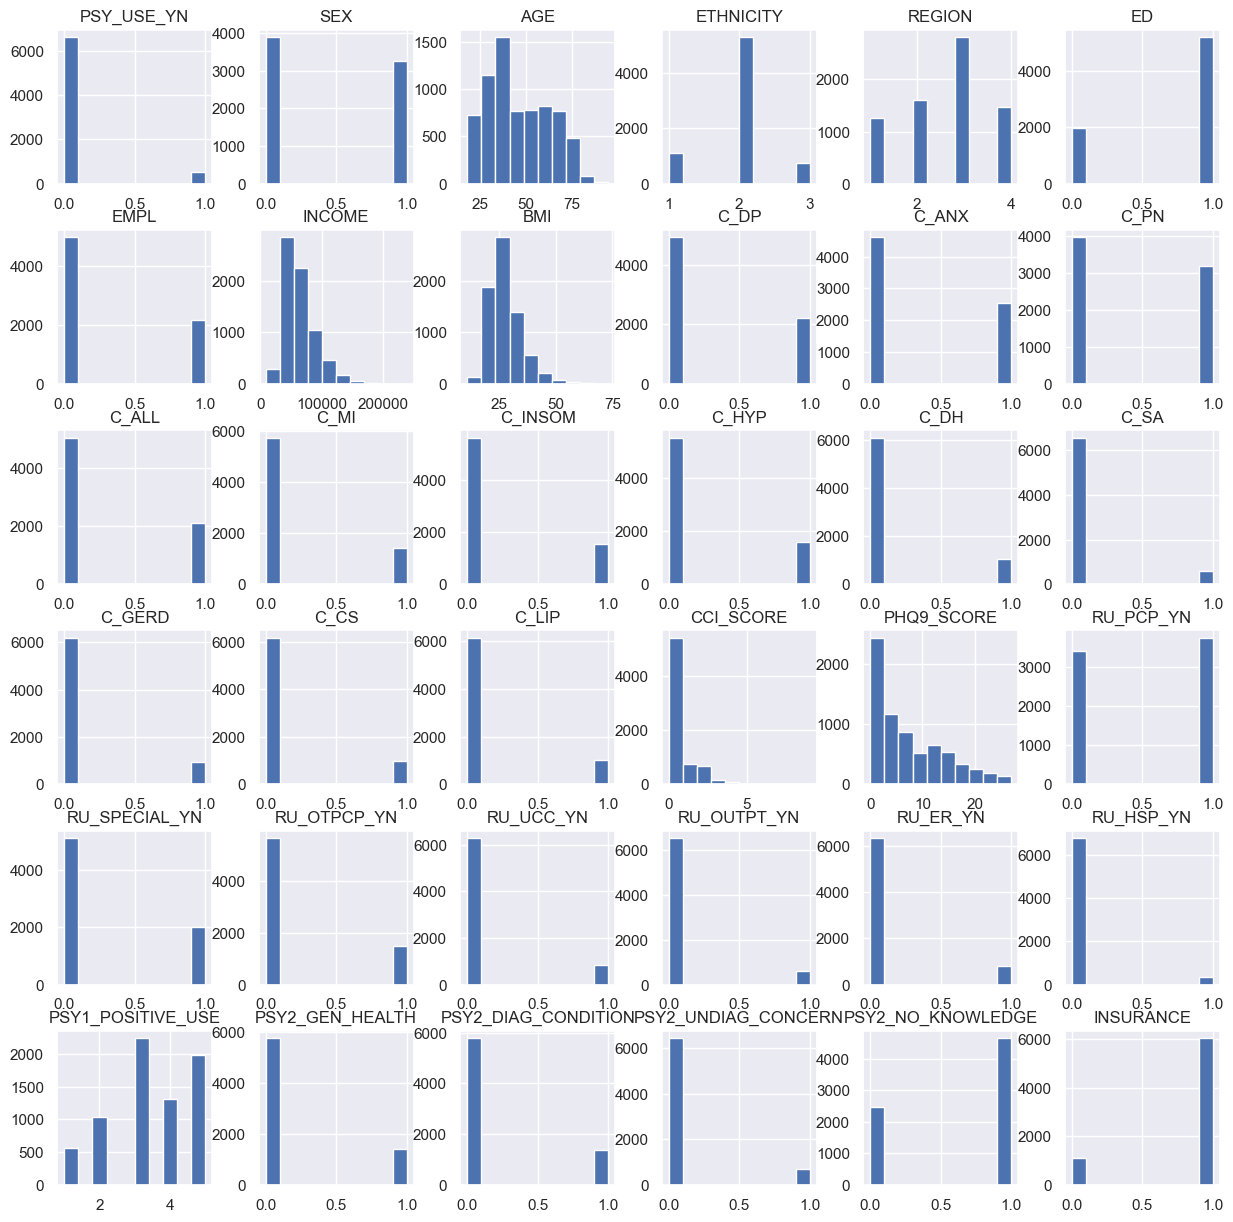

In [23]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.tight_layout()
df.hist();

Most of the data seems to be shewed with left tails, may need to do transformations on the data such as standardization for modeling as well

In [24]:
d= df.groupby( 'PSY_USE_YN')

In [25]:
type(d)

pandas.core.groupby.generic.DataFrameGroupBy

In [26]:
d.head()

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_DP,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
1,1,0,19.000,3,4,0,0,65847,27.410,0.000,...,0,0,0,0,3,1,0,0,0,0
2,1,0,21.000,2,2,1,0,30585,29.260,0.000,...,0,0,1,0,1,0,0,1,0,1
3,1,0,22.000,2,4,0,0,49259,20.600,1.000,...,1,0,1,0,3,1,1,1,0,0
4,1,0,22.000,2,3,1,0,54135,18.560,1.000,...,0,0,0,0,2,1,1,0,0,1
5,1,0,23.000,2,2,0,1,49425,36.800,1.000,...,0,0,1,0,2,1,1,1,0,1
123,0,0,18.000,2,1,0,0,51161,26.660,1.000,...,0,0,1,0,3,0,1,1,0,0
124,0,0,18.000,2,3,0,0,47796,29.530,0.000,...,0,0,1,0,4,0,0,0,1,0
125,0,0,18.000,1,3,1,0,60646,31.750,0.000,...,0,0,1,0,4,0,0,0,1,1
126,0,0,18.000,3,4,0,0,36444,36.320,1.000,...,0,0,0,0,3,0,0,0,1,1


Text(0.5, 1.0, 'ts')

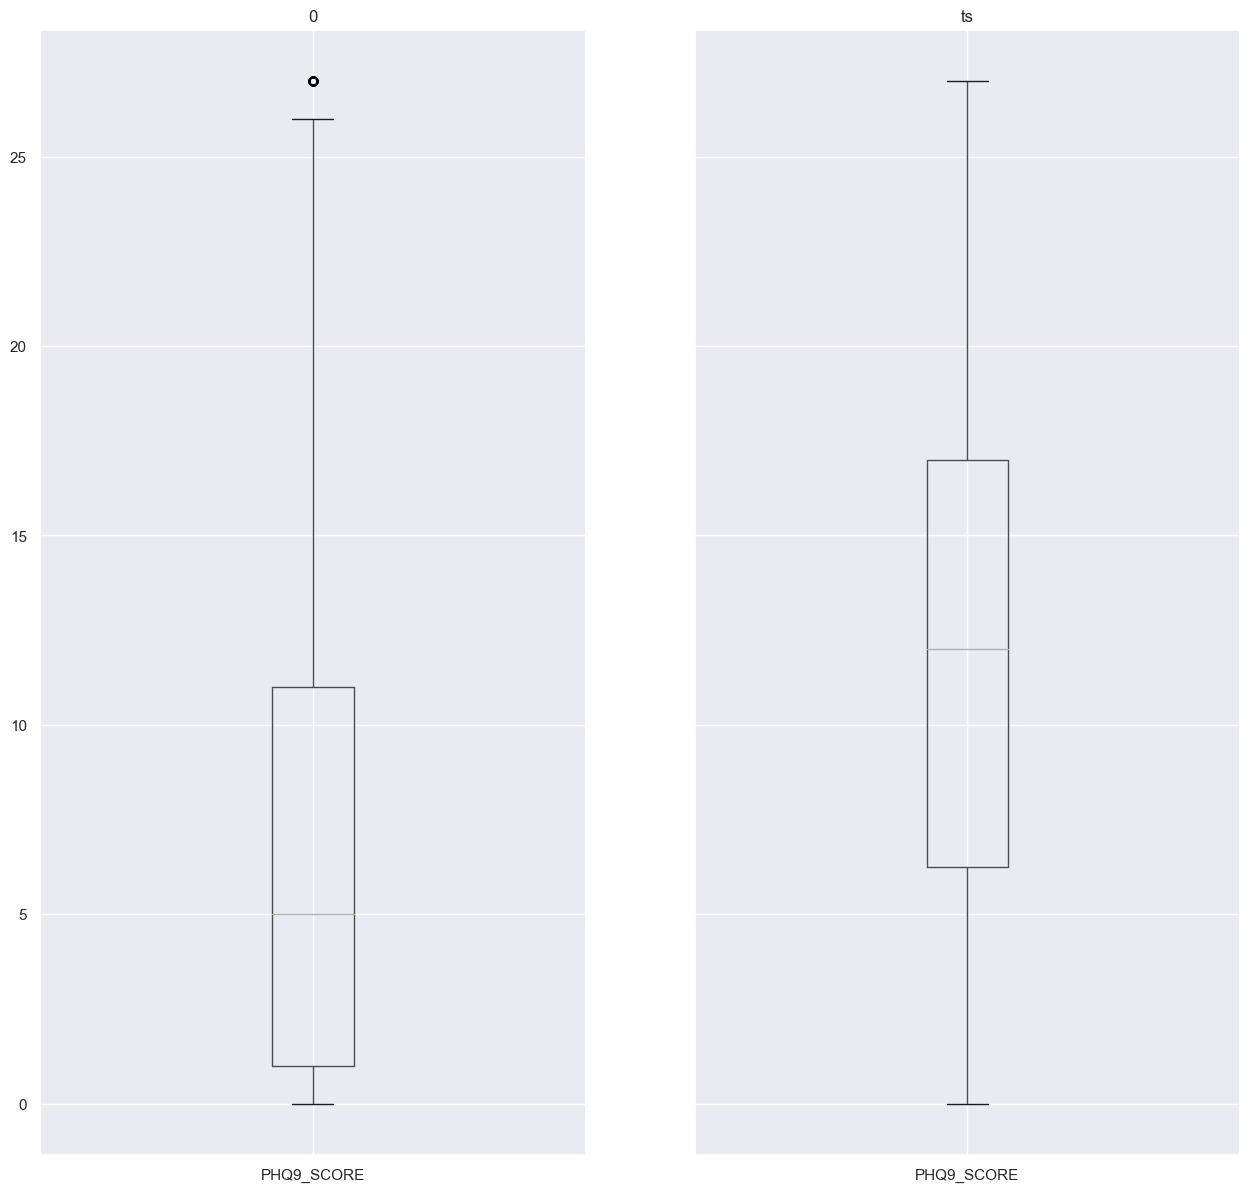

In [27]:
d.boxplot(column='PHQ9_SCORE')
plt.title("st")
plt.title("ts")




Those who take psydelics(1) have a greater average depression severity and wider range. There is some overlap with the Inter quartile range(IQR) but the maximum depression scores for those who took psyedlics is modertely depressed verus moderate depression for those who haven't taken psychedlics. 

In [28]:
df['PHQ9_SCORE'].describe()

count   7,139.000
mean        7.330
std         6.994
min         0.000
25%         1.000
50%         5.000
75%        12.000
max        27.000
Name: PHQ9_SCORE, dtype: float64

**PHQ9_SCORE** has a depression Severity in the range of 0-27 in several categories:

1. Score 1-4: Minimal depression 
2. Score 5-9: Mild depression 
3. Score 10-14: Moderate depression 
4. Score 15-19: Moderately severe depresesion 
5. Score 20-27: Severe depression 

In the function below the raw scores will be remapped into their associated categoires

In [29]:
# inputs: PHQ9 Series of scores, 
# exports a remapped Series depression 


def PHQ9_remap_1(x):
    if (x >= 0) & (x <= 4):
        x = 1
    elif (x >= 5) & (x <= 9):
        x = 2
    elif (x >= 10) & (x <= 14):
        x = 3
    elif (x >= 15) & (x <= 19):
        x = 4 
    else:
        x = 5

    return x 

    
    



In [30]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_1(x['PHQ9_SCORE']), axis=1)

In [31]:
df['PHQ9_SCORE']

CASEID_7139
1       2
2       1
3       4
4       4
5       4
       ..
7135    3
7136    1
7137    1
7138    1
7139    1
Name: PHQ9_SCORE, Length: 7139, dtype: int64

In [32]:
df['PHQ9_SCORE'].value_counts()

1    3286
2    1490
3    1097
4     774
5     492
Name: PHQ9_SCORE, dtype: int64

We can see that the PHQ9 score is unbalanced for the different categories, but thinking about this from a health prespective, those that are > category 1(minimal depression) don't need any type of therapy, so we will remap this into 0(for minimal depression)needing no action and 1(everything above minimal depression) needing action.

In [33]:
# inputs: PHQ9 Series of scores
# exports a remapped Series of 0(needing not therapy) or 1(needing therapy)

def PHQ9_remap_2 (x):
  if x == 1:
    x = 0
  else: 
    x = 1
  return x 

In [34]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_2(x['PHQ9_SCORE']), axis=1)

df.info()

In [35]:
df['PHQ9_SCORE'].sample(10)

CASEID_7139
3011    1
548     0
5077    1
2385    1
4236    0
2271    1
3531    0
2045    1
1169    0
5265    1
Name: PHQ9_SCORE, dtype: int64

In [36]:
df['PHQ9_SCORE'].value_counts()

1    3853
0    3286
Name: PHQ9_SCORE, dtype: int64

The categories are now balanced after remapping and are more useful in terms of a treatment prespective

In [37]:
df['PSY_USE_YN'].value_counts()

0    6613
1     526
Name: PSY_USE_YN, dtype: int64

looks like the 'PSY_USE_YN' column is unbalanced there are a lot more people who did not take psycedlics compared to those who did 

In [38]:
df.head()

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_DP,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
1,1,0,19.000,3,4,0,0,65847,27.410,0.000,...,0,0,0,0,3,1,0,0,0,0
2,1,0,21.000,2,2,1,0,30585,29.260,0.000,...,0,0,1,0,1,0,0,1,0,1
3,1,0,22.000,2,4,0,0,49259,20.600,1.000,...,1,0,1,0,3,1,1,1,0,0
4,1,0,22.000,2,3,1,0,54135,18.560,1.000,...,0,0,0,0,2,1,1,0,0,1
5,1,0,23.000,2,2,0,1,49425,36.800,1.000,...,0,0,1,0,2,1,1,1,0,1


the dataframe is properly cleaned and encoded now, now we need to split the data into train/test sets and scale the continous data features

In [39]:
df_clean = df 

In [40]:
df_clean.sample(5)

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_DP,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
6585,0,1,74.000,2,2,1,0,84225,24.410,0.000,...,0,0,0,0,5,0,0,0,1,1
6923,1,1,29.000,2,2,0,0,79204,28.060,0.000,...,0,0,0,0,2,1,0,0,0,0
5585,0,1,49.000,1,1,1,0,67795,21.770,1.000,...,1,0,0,0,2,0,1,0,0,0
6081,0,1,62.000,1,3,1,0,154245,31.240,0.000,...,0,0,0,0,5,0,0,0,1,1
5237,0,1,41.000,3,3,0,1,57365,35.560,0.000,...,0,0,0,0,3,1,0,0,0,1


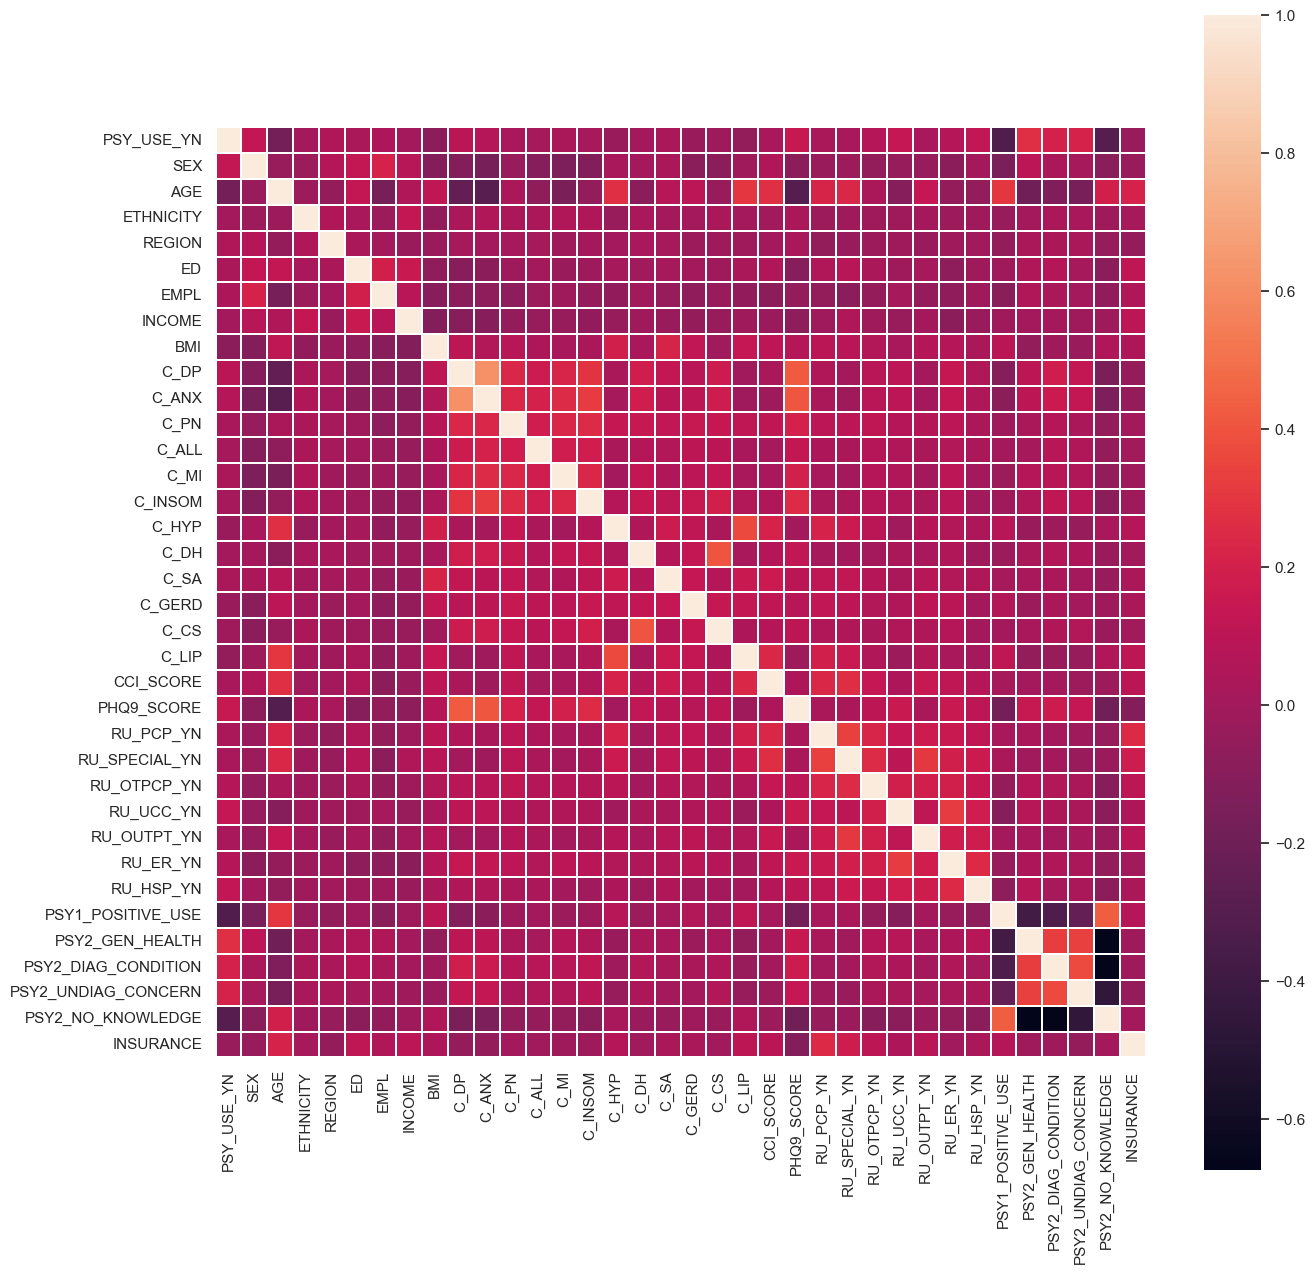

In [41]:
sns.heatmap(df_clean.corr(), square= True,linewidths=.2);

Seems like the **C_DP**(previously had depression) and **C_ANX**(previously had anxiety) are strongly correlated to **PHQ9_Score**(Depression score) which makes sense, but may need to be dropped to improve model performance

# Modeling

In [42]:
X, y = df_clean.loc[:, 'PSY_USE_YN': 'INSURANCE'].drop('PHQ9_SCORE', axis=1).values, df_clean.loc[:, 'PHQ9_SCORE'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 0, \
                                                   stratify = y)

### Linear SVC Model

In [44]:
# make pipeline
pipe_lr = make_pipeline(StandardScaler(), 
                        LinearSVC(max_iter = 5000,random_state =1))

The metrics that will be used is MCC and recall:
- MCC b/c the data is a bit unbalanced in regards to the number of patients that take psy
- recall b/c we want to reduce the number of false negatives, which are patients predicted to be negative, but actually positive



In [45]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_recall = recall_score(y_test, y_pred)
mcc_lr = matthews_corrcoef(y_test, y_pred)

print(f'Test recall: {test_recall}')
print(f'MCC: {mcc_lr}')

Test recall: 0.7491349480968859
MCC: 0.5183856381491374


In [46]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test, y_pred)

print(confmat)

[[760 226]
 [290 866]]


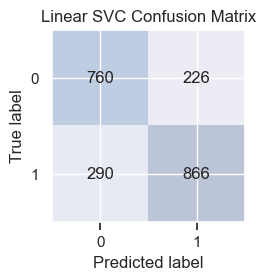

In [47]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)

for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Linear SVC Confusion Matrix');


### SVC Kernel Model

In [48]:
pipe_svc = make_pipeline(StandardScaler(), SVC(max_iter = -1, random_state=0))

For this problem we care more about recall as a performance, which minimises false negatives as oposed to precision which minimised false positives and MCC

In [49]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
test_recall = recall_score(y_test, y_pred)
mcc_lr = matthews_corrcoef(y_test, y_pred)


print(f'Test recall: {test_recall}')
print(f'MCC: {mcc_lr}')

Test recall: 0.7707612456747405
MCC: 0.5157035181660333


In [50]:
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[735 251]
 [265 891]]


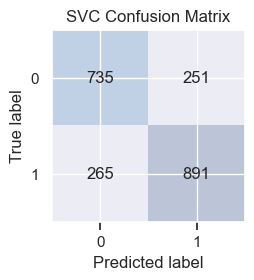

In [51]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('SVC Confusion Matrix');

### Tune Models via RandomizedSearch

In [52]:
pipe_svc = make_pipeline(StandardScaler(), SVC(cache_size= 1000, random_state=0, max_iter= -1))

In [53]:
pipe_svc.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('svc', SVC(cache_size=1000, random_state=0))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(cache_size=1000, random_state=0),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 1000,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 0,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [54]:
#scoring = {'Recall': 'recall', "MCC": make_scorer(matthews_corrcoef)}

In [55]:
param_range = loguniform(0.0001, 1000.0)

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']
               },
              {'svc__C': param_range,
               'svc__kernel': ['rbf'],
                'svc__gamma': param_range
               }]
             

rs = RandomizedSearchCV(estimator=pipe_svc,
                   param_distributions=param_grid,
                   scoring=make_scorer(matthews_corrcoef),
                   cv=10,
                   refit=True,
                   n_jobs=-1,
                   n_iter=20,
                   random_state=1)

rs = rs.fit(X_train, y_train)

print(rs.best_score_)
print(rs.best_params_)


0.47336392815536926
{'svc__C': 17.26472164275692, 'svc__kernel': 'linear'}


In [56]:
pipe_knn = make_pipeline(StandardScaler(),KNeighborsClassifier())

In [57]:
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
test_recall = recall_score(y_test, y_pred)
mcc_lr = matthews_corrcoef(y_test, y_pred)
print(f'Test recall: {test_recall}')
print(f'MCC: {mcc_lr}')

Test recall: 0.6695501730103807
MCC: 0.4285042082721166


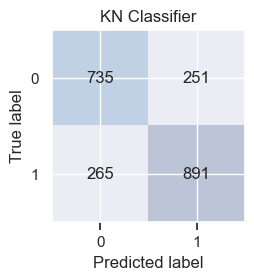

In [58]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('KN Classifier');

In [59]:
pipe_knn.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [60]:
param_range = list(range(1,50))

param_grid = {'kneighborsclassifier__n_neighbors': param_range,
               'kneighborsclassifier__p': [1,2]
               }
             

kn = RandomizedSearchCV(estimator=pipe_knn,
                   param_distributions=param_grid,
                   scoring=make_scorer(matthews_corrcoef),
                   cv=10,
                   refit=True,
                   n_jobs=-1,
                   n_iter=20,
                   random_state=1)

kn = kn.fit(X_train, y_train)

print(kn.best_score_)
print(kn.best_params_)

0.45361622284533826
{'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 33}


not the best MCC score for what we have tried so far

### Ensomble Methods

#### Random Forest

In [61]:
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0, n_jobs=-1))

pipe_rf.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
test_recall_rf = recall_score(y_test, y_pred)
mcc_rf = matthews_corrcoef(y_test, y_pred)
print(f'Test recall: {test_recall_rf}')
print(f'MCC: {mcc_rf}')



Test recall: 0.6695501730103807
MCC: 0.4285042082721166


In [62]:
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[749 237]
 [382 774]]


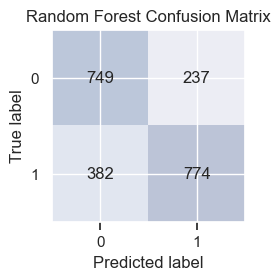

In [63]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Confusion Matrix');

#### Random Forest Tuning 

In [64]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier',
   RandomForestClassifier(n_jobs=-1, random_state=0))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(n_jobs=-1, random_state=0),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__maxBins': 256,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__minBinSize': 1,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomfo

In [65]:
param_range = list(range(1,200))

param_grid = {'randomforestclassifier__n_estimators': param_range,
               'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
               }
             

kn = RandomizedSearchCV(estimator=pipe_rf,
                   param_distributions=param_grid,
                   scoring=make_scorer(matthews_corrcoef),
                   cv=10,
                   refit=True,
                   n_jobs=-1,
                   n_iter=20,
                   random_state=1)

kn = kn.fit(X_train, y_train)

print(kn.best_score_)
print(kn.best_params_)

C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Stephen\anaconda3\lib\site-packages\daal4py\sklearn\ensemble\_forest.py", line 672, in fit
    return _fit_classifier(self, X, y, sampl

0.4629401639860776
{'randomforestclassifier__n_estimators': 87, 'randomforestclassifier__criterion': 'entropy'}


### XGBC classifier 

In [66]:
model = xgb.XGBClassifier(n_estimators=3000, learning_rate=.001, 
                          max_depth= 4, random_state=1)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train_recall = recall_score(y_train, y_train_pred)
gbm_test_recall = recall_score(y_test, y_test_pred)

gbm_train_mcc = matthews_corrcoef(y_train, y_train_pred)
gbm_test_mcc = matthews_corrcoef(y_test, y_test_pred)


print(f'XGboost train/test recall: {gbm_train_recall}/{gbm_test_recall}')
print(f'XGboost train/test mcc: {gbm_train_mcc}/{gbm_test_mcc}')

[16:10:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Stephen\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGboost train/test recall: 0.7404523544679273/0.7525951557093425
XGboost train/test mcc: 0.5279203102904275/0.521877469882412


In [67]:
confmat = confusion_matrix(y_test, y_test_pred)
print(confmat)

[[760 226]
 [286 870]]


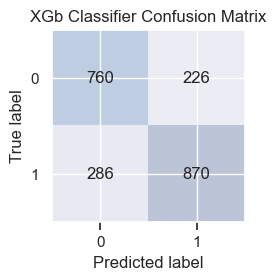

In [68]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('XGb Classifier Confusion Matrix');

### Voting Classifer

In [69]:
knn_best = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors= 33, n_jobs=-1))
rf_best = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators = 87, criterion= 'entropy'))
svc_best = make_pipeline(StandardScaler(), SVC(C = 17.264,kernel = 'linear',  cache_size= 1000, random_state=0, max_iter= -1 ))


#create a dictionary of our models
estimators=[('knn', knn_best), ('svc', svc_best), ('rf', rf_best)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
test_recall = recall_score(y_test, y_pred)
mcc_lr = matthews_corrcoef(y_test, y_pred)

print(f'Test recall: {test_recall}')
print(f'MCC: {mcc_lr}')



Test recall: 0.7240484429065744
MCC: 0.5157229609917995


In [70]:
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[782 204]
 [319 837]]


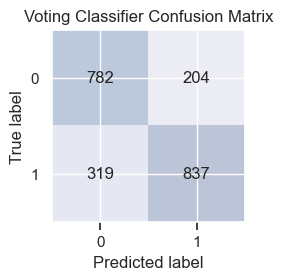

In [71]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Voting Classifier Confusion Matrix');

Overall the SVC model has the best performance on the recall(because we want to reduce false negatives) and MCC score 

Test recall: 0.7707612456747405
MCC: 0.5157035181660333
